# Setup
Run below cells and hide it afterwards with the arrow on the left. 

In [0]:
!pip install gym[Box2D] pyvirtualdisplay pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import math
import glob
import io
import base64
from IPython.display import HTML

from typing import List, Tuple

import torch
from torch import nn
import torch.nn.functional as F
from collections import deque

from IPython import display as ipythondisplay
from IPython.display import display, update_display, clear_output
from time import sleep

from pyvirtualdisplay import Display
xdisplay = Display(visible=0, size=(1300, 900), backend="xvfb")
xdisplay.start()


"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

class DoneWrapper(gym.Wrapper):

  def step(self, action):
    observation, reward, done, info = self.env.step(action) 
    return observation, reward, False, info
      

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
    
def wrap_env(env, done=True):
  if not done:
    env = DoneWrapper(env)
  env = Monitor(env, './video', force=True, mode='evaluation')
  return env


def print_ansi(screen, display_id='42', wait=0.5):
    clear_output(wait=True)
    update_display(print(screen.getvalue()), display_id=display_id)
    sleep(wait)


def plot(img):
  fig = plt.figure(figsize=(8,6))
  ax = fig.add_subplot(111)
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


# Part 1. The Agent and The Environment
Here we are going to familiarize ourselves with basic Reinforcement Learning concepts: environments and agent. 

Through the whole workshop we will be using the `gym` package for our environment, here's an example of a classic control task.

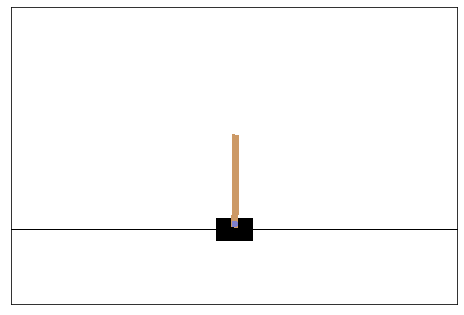

In [3]:
import gym

# create the environemnt
env = gym.make("CartPole-v1")
# reset the env and initilize it
env.reset()
# plot the visualisation
plot(env.render(mode='rgb_array'))

In [4]:
# state/observation space
print(env.observation_space)
print("max:", env.observation_space.high)
print("min:", env.observation_space.low)

Box(4,)
max: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
min: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


**Question:** Can you guess what are those four numbers?

In [0]:
# action space
print(env.action_space)
print("random action:", env.action_space.sample())

Discrete(2)
random action: 1


**Question:** Again, can you guess what are those to actions?

Let's see how do we (or specifically the agent) can interact with the environment.

In [0]:
# set the limit on steps taken
max_steps = 200

# create the environment again
env = wrap_env(gym.make("CartPole-v1"), done=False)
# reset it
env.reset()
# plot
env.render()

# interact with the environemnt 
for i in range(max_steps):
  
    # sample a random action
    action = env.action_space.sample()

    # act with the sampled action
    observation, reward, done, info = env.step(action) 

    # plot
    env.render()
  
# close the env
env.close()
# visualise the interaction
show_video()

**Mini-exercise:** Change random action to a constant one.

## Exercise: Manual control on a more complicated environment.

Try to "manually" solve the moon lander problem

State space representation:
```
[x position,   
 y position,
 x velocity,
 y velocity,
 lander angle,
 angular velocity,
 ??,
 ??]
``` 

Action space representation:
```
[no operation
left engine,
main (bottom) engine,
right engine]
```

In [0]:
# create the environment (again)
env = wrap_env(gym.make("LunarLander-v2"))
# reset
observation = env.reset()
# plot
env.render()

# interact with the environemnt 
while True:

    # change the constant action here to some heuristic 
    # base on the state
    action: int = 2

    # act with the choosen action
    observation, reward, done, info = env.step(action) 

    # plotting
    env.render()

    # break the loop on game end
    if done:
        break
  
env.close()
show_video()

## Exercise: Build a class for your Moon Lander policy.

We would like to have some abstraction for our Policies, move your solution to the class skeleton below. 

In [0]:
class ManualPolicy:

  def sample(self, obs: np.ndarray):
      """Pick an action based on the current state"""

      # move your code here
      action = 2
      
      return action

Use your new policy class in the function below.


In [0]:
def visualize(env, policy):
    """Run the provided policy on the environment"""

    env = wrap_env(env)
    obs = env.reset()
    done = False
    
    while not done:
        action = policy.sample(obs) # ???
        obs, reward, done, _ = env.step(action)
        env.render()

    env.close()
    show_video()

In [0]:
# moon lander
env = gym.make("LunarLander-v2")
# your policy
policy = ManualPolicy()

visualize(env, policy)

## Exercise: Random Policy
We would like to compare our policy to a *random* agent, let's implement another policy class, this time a more generic one that can work for various environments.

Implement the `RandomPolicy` class using methods from the PyTorch package.

**Hint:** For random sampling you can use [`torch.multinomial`](https://pytorch.org/docs/stable/torch.html#torch.multinomial) function.

In [0]:
import torch

class RandomPolicy:
    """Policy that takes uniformly random actions"""

    def __init__(self, action_dim: int):
        # save action dimensionality
        self.action_dim = action_dim

    def probs(self):
        # create a tensor with uniform probability for each action
        # make sure that the returned type is torch.float

        # ???
        probs = [1 / self.action_dim] * self.action_dim
        return torch.tensor(probs, dtype=torch.float32)

    def sample(self, obs: np.ndarray):
        # sample from the prepared probability vector
        # * here you can disregard the `obs` parameterm as our random action is 
        #   independent of the observation
        # * because the suggested sampling method returns a tensor, you may need
        #   to use the `.item()` method on the returned tensor to get an int  

        # ???
        probs = self.probs()
        action = torch.multinomial(probs, num_samples=1).item()
        return action


Test the Random Policy.

In [0]:
# moon lander
env = gym.make("LunarLander-v2")
# your policy
policy = RandomPolicy(action_dim=env.action_space.n)

visualize(env, policy)

## Exercise: Gathering Trajectories
To compare your Policy to a Random one we need to many *episodes* to get a better picture of how they perform. Here we will gather many trajectories to later compare the performance of the models.


Implement the missing code in the function below to gather trajectories, a single element of a trajectory should be a tuple consisting of:
`[state, action_taken, reward, done_flag]`

In [0]:
def gather_trajectories(env: gym.Env, policy, num_trajs: int = 10):
    """Gather `num_trajs` trajectories by interacting with the environment using the given policy."""
    
    # prepare a list for the trajectories
    history = []
    
    for traj_idx in range(num_trajs):
        obs = env.reset()
        done = False
        current_traj = []
        while not done:
            
            # sample an action from the policy
            action = policy.sample(obs) # ???
            # feed it into the environment
            next_obs, reward, done, _ = env.step(action) # ???
            
            # save into the history
            current_traj += [(obs, action, reward)] # ???

            obs = next_obs
        history += [current_traj]
        
    return history

In [0]:
env = gym.make("LunarLander-v2")

manual_policy = ManualPolicy()
random_policy = RandomPolicy(action_dim=env.action_space.n)

# this may take a few seconds
manual_history = gather_trajectories(env, manual_policy)
random_history = gather_trajectories(env, random_policy)

## Exercise: Processing Trajectories

Now that we have the episode records we can process the trajectories to get some statistics, but we need one more thing. We will compare our policies on the sum of rewards and the end of each episode, called *return*. Later we will need a return for each step of the interaction, so let's implement it right now. As a remainder, a step return is defined as:

$$ R_t = \sum_{j=t}^{T} r_j$$

and the episode return with the episode trajectory $\tau$ is simply:

$$ R(\tau) =  \sum_{j=1}^{T} r_j $$

In [0]:
def calculate_return(rewards: List[float]) -> Tuple[float, List[float]]:
    """Calulate episode and step returns"""
    # calculate the sum of rewards from the episode
    rewards = np.array(rewards)
    episode_return = np.sum(rewards)
    
    # prepare a list for the step returns
    step_returns = []

    # calculate discounted return for each step
    # hint: it's easier to go backwards
    step_returns = [rewards[-1]]
    for reward in reversed(rewards[:-1]):
        last_return = step_returns[-1]
        step_returns += [reward + last_return]
    
    step_returns.reverse()

    return episode_return, step_returns

With that function ready we can use it to process our history. Implement the `process_trajectories` function, don't forget to use the `calculate_return` function that you've just implemented.

In [0]:
def process_trajectories(history: List):
    """Process gathered trajectories into tensors and calculate returns"""
    # prepare containers for each element
    obs_array = []
    action_array = []
    return_array = []
    episode_returns = []
    
    # loop over the whole history
    rewards = []
    for traj_idx, traj in enumerate(history):
        # unpack the elements
        traj_obs, traj_actions, traj_rewards = list(zip(*traj))

        # process the episode - calculate episode and step returns
        # ???
        episode_return, step_returns = calculate_return(traj_rewards)
        
        episode_returns += [episode_return]
        obs_array += traj_obs
        action_array += traj_actions
        return_array += step_returns

    # cast out data to tensors (will be useful later)     
    obs_array = torch.tensor(obs_array, dtype=torch.float32)
    action_array = torch.tensor(action_array, dtype=torch.float32)
    return_array = torch.tensor(return_array, dtype=torch.float32)
    episode_returns = torch.tensor(episode_returns, dtype=torch.float32)
    
    return obs_array, action_array, return_array, episode_returns

With all that we can compare your policy to the random one, will plot here the returns for each consecutive episode.

Average manual policy episode return: -731.538
Average random policy episode return: -147.556


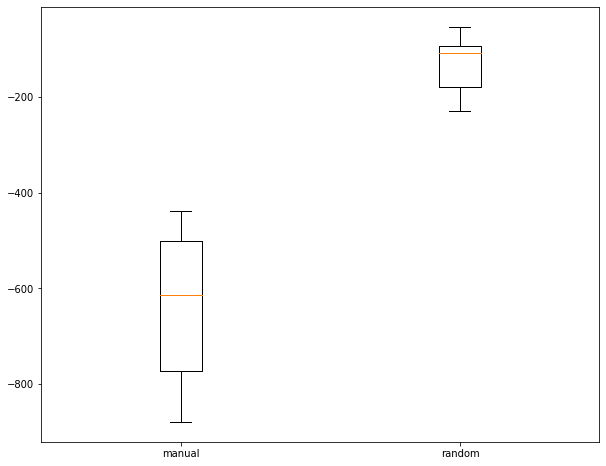

In [0]:
manual_stats = process_trajectories(manual_history)
random_stats = process_trajectories(random_history)

manual_returns = manual_stats[-1]
random_returns = random_stats[-1]

plt.boxplot([manual_returns.numpy(), random_returns.numpy()], labels=['manual', 'random'], sym="")

print(f"Average manual policy episode return: {manual_returns.mean():.3f}")
print(f"Average random policy episode return: {random_returns.mean():.3f}")

## Free Play
If you want to try to write a better policy here's the whole code in one place.

Average manual policy episode return: -965.175
Average random policy episode return: -178.926


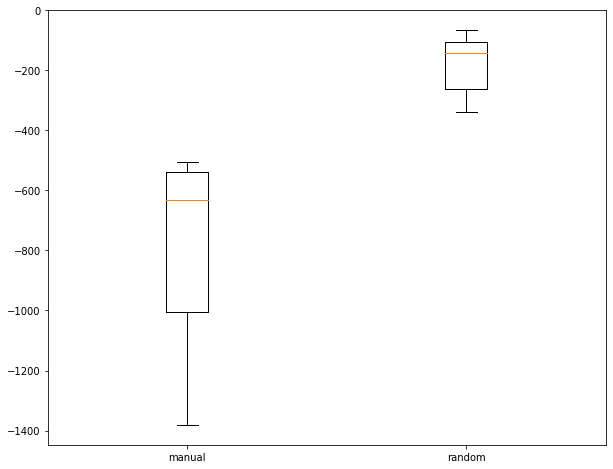

In [0]:
class ManualPolicy:

  def sample(self, obs: np.ndarray):
      """Pick an action based on the current state"""

      # your code here
      action = 0
      
      return action

# moon lander
env = gym.make("LunarLander-v2")

# random policy
policy = RandomPolicy(action_dim=env.action_space.n)
# your policy
policy = ManualPolicy()

# gather trajectories
manual_history = gather_trajectories(env, manual_policy)
random_history = gather_trajectories(env, random_policy)

# process trajectories
manual_stats = process_trajectories(manual_history)
random_stats = process_trajectories(random_history)

# get episode returns
manual_returns = manual_stats[-1]
random_returns = random_stats[-1]

# visualize
plt.boxplot([manual_returns.numpy(), random_returns.numpy()], labels=['manual', 'random'], sym="")

print(f"Average manual policy episode return: {manual_returns.mean():.3f}")
print(f"Average random policy episode return: {random_returns.mean():.3f}")
